In [ ]:
import time
import concurrent.futures
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd


In [7]:
class Material:
    def __init__(self, sigma_t, sigma_s, volumetric_source):
        self.sigma_t = sigma_t
        self.sigma_s = sigma_s
        self.sigma_a = sigma_t - sigma_s
        self.volumetric_source = volumetric_source
        
class Cell:
    def __init__(self, index, xloc, material, length):
        self.id = index
        self.xloc = xloc
        self.material = material
        self.length = length
        
class Mesh:
    def __init__(self, lengths : list[float], materials : list[Material], dx : float):
        for length in lengths:
            assert length / dx == int(length / dx), "length must be a multiple of dx"
        self.lengths = lengths
        self.total_length = sum(lengths)
        self.dx = dx

        self.cells = []
        idx = 0
        for length, material in zip(lengths, materials):
            for i in range(int(length / dx)):
                self.cells.append(Cell(idx, idx*dx, material, dx))
                idx += 1
                
        self.n_cells = len(self.cells)
                
    def get_cell(self, x):
        cell_index = int(x / self.dx) # floor
        if cell_index == self.n_cells:
            return self.cells[-1]
        return self.cells[cell_index]
    
    def get_cell_x_positions(self):
        return [cell.xloc + self.dx/2 for cell in self.cells]
    
    def get_suface_x_positions(self):
        return [cell.xloc for cell in self.cells] + [self.total_length]

In [8]:
class DiscreteOrdinates:
    def __init__(
        self,
        angles,
        weights,
        mesh,
        left_boundary,
        right_boundary,
        title_start="",
    ):

        self.angles = angles
        self.weights = weights
        self.mesh = mesh
        self.n_cells = mesh.n_cells
        self.n_surfaces = self.n_cells + 1

        assert (
            isinstance(left_boundary, (int, float)) or left_boundary == "reflecting"
        ), "left_boundary must be a float or 'reflecting'"
        self.left_boundary = left_boundary
        assert (
            isinstance(right_boundary, (int, float)) or right_boundary == "reflecting"
        ), "right_boundary must be a float or 'reflecting'"
        self.right_boundary = right_boundary

        self.title_start = title_start

        assert np.all(np.array(angles) != 0), "angles must not be zero"

        self.angular_fluxes_at_surfaces = np.zeros((self.n_surfaces, len(angles)))

        self.average_scalar_flux_at_cells = np.zeros(self.n_cells)

    def angular_flux(self, max_iter=20000, tol=1e-10):

        angular_flux_matrix_objs = {
            angle: AngularFluxMatrix(self, angle) for angle in self.angles
        }
        zero_block = np.zeros((self.n_surfaces, self.n_surfaces))
        number_of_angles = len(self.angles)

        block_matrix_components = (
            []
        )  # this will be a list of lists, where outer list components are rows
        for block_index, angle in enumerate(self.angles):
            submatrix = angular_flux_matrix_objs[angle].A_mat
            row = (
                block_index * [zero_block]
                + [submatrix]
                + (number_of_angles - block_index - 1) * [zero_block]
            )

            block_matrix_components.append(row)

        block_matrix = np.bmat(block_matrix_components)

        # apply neumman boundary condition to boundary
        # this could be better, but homework...
        if self.left_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_pos_angle * self.n_surfaces, nth_neg_angle * self.n_surfaces
                    ] = -1

        if self.right_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_neg_angle * self.n_surfaces + self.n_surfaces - 1,
                        nth_pos_angle * self.n_surfaces + self.n_surfaces - 1,
                    ] = -1

        start_time = time.time()
        for iter in range(max_iter):

            # scalar flux at each node

            old_scalar_flux = self.average_scalar_flux_at_cells.copy()

            # generate the b vector based on the old scalar flux
            b_vec = np.concatenate(
                [
                    angular_flux_matrix_objs[angle].b_vec(
                        old_scalar_flux
                    )
                    for angle in self.angles
                ]
            )

            angular_flux_long = np.linalg.solve(block_matrix, b_vec)

            # list where each element is a list of angular fluxes for each angle
            # the same order as self.angles
            self.angular_fluxes_at_surfaces = np.split(
                angular_flux_long, number_of_angles
            )

            self.angular_fluxes_at_cells = [
                angular_flux_matrix_objs[angle].average_angular_flux(
                    self.angular_fluxes_at_surfaces[i]
                )
                for i, angle in enumerate(self.angles)
            ]

            self.average_scalar_flux_at_cells = sum(
                angular_flux_at_angle * weight
                for angular_flux_at_angle, weight in zip(
                    self.angular_fluxes_at_cells, self.weights
                )
            )

            if np.allclose(
                old_scalar_flux, self.average_scalar_flux_at_cells, atol=tol
            ):
                print(f"{self.title_start}: Converged after {iter} iterations")
                end_time = time.time()
                self.solver_time = end_time - start_time
                break

            if iter == max_iter - 1:
                end_time = time.time()
                self.solver_time = end_time - start_time
                print(f"{self.title_start}: Did not converge after {iter} iterations")

        return self.average_scalar_flux_at_cells

    def plot(self):
        fig, ax = plt.subplots()

        ax.plot(
            self.mesh.get_cell_x_positions(),
            self.average_scalar_flux_at_cells,
            label=r"$\langle \phi \rangle$",
            color="purple",
        )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_surfaces):
            ax.scatter(
                self.mesh.get_suface_x_positions(),
                angular_fluxes,
                label=rf"$\psi$ surf $\mu=${angle:.2f}",
                marker="x",
            )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_cells):
            ax.scatter(
                self.mesh.get_cell_x_positions(),
                angular_fluxes,
                label=rf"$\langle \psi \rangle$ cell at $\mu=${angle:.2f}",
                marker="o",
            )

        # ax.set_ylabel(r"$\langle \phi \rangle$")
        ax.set_xlabel("x")
        ax.legend()
        ax.set_title(self.title_start)

        return fig, ax

    def angular_flux_at_xloc(self, xloc):
        # find nearest cell
        cell_index = np.argmin(np.abs(self.cell_x_pos - xloc))

        angular_flux_per_angle = np.array(
            [angular_flux[cell_index] for angular_flux in self.angular_fluxes_at_cells]
        )

        return self.angles, angular_flux_per_angle

    def current(self):
        scalar_flux_derivative = np.gradient(
            self.average_scalar_flux_at_cells, self.cell_x_pos
        )
        transport_xs = self.sigma_t - 0  # since Sigma_s1 = 0
        diffusion_coeff = 1 / 3 / transport_xs
        current = -diffusion_coeff * scalar_flux_derivative
        return self.cell_x_pos, current

    def angular_moments(self, number_of_moments=8):
        legendre_polynomials = [
            sp.special.legendre(i) for i in range(number_of_moments)
        ]

        angular_flux_moments = {}

        for moment_p in range(number_of_moments):
            legendre_polynomial = sp.special.legendre(moment_p)
            angular_flux_moments[moment_p] = sum([
                weight_m * legendre_polynomial(mu_m) * angular_flux_at_cell
                for weight_m, mu_m, angular_flux_at_cell in zip(
                    self.weights, self.angles, self.angular_fluxes_at_cells
                )
            ])

        # reconstruct the angular fluxes from the moments
        angular_fluxes_reconstructed = {}
        for angle in self.angles:
            angular_fluxes_reconstructed[angle] = sum([
                angular_flux_moments[moment_p] * legendre_polynomials[moment_p](angle) * (2 * moment_p + 1) / 2
                for moment_p in range(number_of_moments)
            ])

        return angular_flux_moments, angular_fluxes_reconstructed

    def angular_moments_plot(self):
        angular_flux_moments, angular_fluxes_reconstructed = self.angular_moments()

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        for moment_p, angular_flux_moment in angular_flux_moments.items():
            ax[0].plot(self.cell_x_pos, angular_flux_moment, label=f"P{moment_p}")

        ax[0].set_title("Angular Flux Moments")
        ax[0].set_xlabel("x")
        ax[0].set_ylabel(r"$\phi^p$")
        ax[0].legend()

        for angle, angular_flux in angular_fluxes_reconstructed.items():
            ax[1].plot(self.cell_x_pos, angular_flux, label=f"{angle:.2f}")

        ax[1].set_title("Reconstructed Angular Fluxes")
        ax[1].set_xlabel("x")
        ax[1].set_ylabel(r"$\psi(\mu)$")
        ax[1].legend(title=r"$\mu$")

        reconstructed_scalar_flux = sum([
            angular_flux * weight
            for angular_flux, weight in zip(angular_fluxes_reconstructed.values(), self.weights)
        ])

        ax[2].plot(self.cell_x_pos, self.average_scalar_flux_at_cells, label="Original")
        ax[2].scatter(self.cell_x_pos, reconstructed_scalar_flux, label="Reconstructed")
        ax[2].set_title("Scalar Flux")
        ax[2].set_xlabel("x")
        ax[2].legend()

        # add text in the center above the plots
        fig.text(0.5, 0.95, self.title_start, ha='center', va='center')

        return fig, ax

class AngularFluxMatrix:
    def __init__(self, discrete_ordinates: DiscreteOrdinates, mu):
        self.mu = mu
        self.discrete_ordinates: DiscreteOrdinates = discrete_ordinates

        self.sign_of_direction = np.sign(mu)
        self.surface_angular_flux = np.zeros(self.discrete_ordinates.n_surfaces)
        self.cell_averaged_angular_flux = np.zeros(self.discrete_ordinates.n_cells)

        self.diag_index = int(-1 * self.sign_of_direction)

        self.A_mat = np.eye(
            self.discrete_ordinates.n_surfaces)

        for idx in range(self.discrete_ordinates.n_cells):
            cell = self.discrete_ordinates.mesh.cells[idx]
            tau = cell.material.sigma_t * self.sign_of_direction * cell.length / self.mu
            value = -np.exp(-tau)
            if self.sign_of_direction > 0:
                self.A_mat[idx+1, idx] = value
            elif self.sign_of_direction < 0:
                self.A_mat[idx, idx+1] = value

    def b_vec(self, scalar_flux_at_cell):

        # self.source_at_cell = [
        #     (cell.material.volumetric_source + scalar_flux * cell.material.sigma_s) / 2
        #     for cell, scalar_flux in zip(self.discrete_ordinates.mesh.cells, scalar_flux_at_cell)
        # ]

        # source_at_cell_with_decay = []
        # for source, cell in zip(self.source_at_cell, self.discrete_ordinates.mesh.cells):
        #     # tau = cell.material.sigma_t * self.sign_of_direction * cell.length / self.mu
        #     tau = abs(cell.material.sigma_t * cell.length / self.mu)
        #     if tau >= 3:
        #         print(f"Warning: tau is {tau} for cell {cell.id}")
        #     source_at_cell_with_decay.append(source / cell.material.sigma_t * (1 - np.exp(-tau)))
        source =[]
        for cell_idx, cell in enumerate(self.discrete_ordinates.mesh.cells):
            tau = abs(cell.material.sigma_t * cell.length / self.mu)
            if tau >= 3:
                print(f"Warning: tau is {tau} for cell {cell.id}")
                print(f"sigma_s: {cell.material.sigma_s}, N: {self.discrete_ordinates.mesh.n_cells}, mu: {self.mu}")
            tau_exp = np.exp(-tau)
            
            fixed_source = cell.material.volumetric_source * (1 - tau_exp)/2
            scatter_source = scalar_flux_at_cell[cell_idx] * cell.material.sigma_s * (1 - tau_exp)/2
            source.append((fixed_source + scatter_source)/cell.material.sigma_t)
            

        if self.sign_of_direction > 0:
            if isinstance(self.discrete_ordinates.left_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.left_boundary
                # I am being lazy with the vacuum boundary condition
                # (not using the extrapolation distance)
            else:
                psi_initial = 0
            return [psi_initial] + source

        elif self.sign_of_direction < 0:
            if isinstance(self.discrete_ordinates.right_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.right_boundary
            else:
                psi_initial = 0
            return source + [psi_initial]

        else:
            raise ValueError("Direction must be positive or negative")

    def average_angular_flux(self, angular_flux_surface):
        # this is really bad code design (dependent on self.source_at_cell/decay_coeff)
        # , but the source at the cell was set up
        # when the b vector was generated...
        # That is, b_vec must have already been run

        # A_coeff = lambda i : self.source_at_cell[i] / self.discrete_ordinates.sigma_t
        old_scalar_flux = self.discrete_ordinates.average_scalar_flux_at_cells

        angular_flux_cell_average = np.zeros(self.discrete_ordinates.n_cells)
        # for i in range(1, self.discrete_ordinates.n_surfaces):
        for cell in self.discrete_ordinates.mesh.cells:
            i = cell.id
            flux_left = angular_flux_surface[i]
            flux_right = angular_flux_surface[i+1]

            source = (cell.material.sigma_s * old_scalar_flux[i] + cell.material.volumetric_source)/2
            A_coeff = source / cell.material.sigma_t

            B_coeff = -self.mu / cell.material.sigma_t / cell.length

            angular_flux_cell_average[i] = A_coeff + B_coeff * (flux_right -flux_left)

        return angular_flux_cell_average


def test_convergence(
    problem, number_of_cells, name="a", sigma_s_over_sigma_t_ratios=[0, 0.01, 0.99, 1]
):
    sigma_t = 1
    orders_of_convergence = {}
    error_dict = {}

    for sigma_s_over_sigma_t in sigma_s_over_sigma_t_ratios:
        solutions = []
        fig_sol, ax_sol = plt.subplots()
        ax_sol.set_title(f"Sn $\Sigma_s/\Sigma_t={sigma_s_over_sigma_t}$")
        for n_cells in number_of_cells[sigma_s_over_sigma_t]:
            sigma_s = sigma_s_over_sigma_t * sigma_t

            solution = problem(n_cells, sigma_s, sigma_t)
            solutions.append(solution)
            
            x_pos = np.linspace(0, 1, len(solution))
            ax_sol.plot(x_pos, solution, label=f"N={n_cells}")

        truth = solutions[-1]
        errors = []
        for solution in solutions[:-1]:
            step = int(len(truth) / len(solution))
            sliced_truth = truth[::step]
            error = np.linalg.norm(np.array(sliced_truth) - np.array(solution))
            errors.append(error)
        error_dict[sigma_s_over_sigma_t] = errors
        orders_of_convergence[sigma_s_over_sigma_t] = order_of_convergence(number_of_cells[sigma_s_over_sigma_t][:-1], errors)
            
        ax_sol.legend(title="Number of Cells")
        fig_sol.show()
    
    fig, ax = plt.subplots()

    for sigma_s_over_sigma_t, errors in error_dict.items():
        ax.plot(
            number_of_cells[sigma_s_over_sigma_t][:-1],
            errors,
            label=f"{sigma_s_over_sigma_t} ({orders_of_convergence[sigma_s_over_sigma_t]:.2f})",
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(title=rf"$\frac{{\Sigma_s}}{{\Sigma_t}}$ (Conv. Order)")
    ax.set_xlabel("Number of Cells")
    ax.set_ylabel("Error")
    ax.set_title(f"2{name}) Sn (S16)")
    
    return fig_sol, ax_sol, fig, ax

<>:353: SyntaxWarning: invalid escape sequence '\S'
<>:353: SyntaxWarning: invalid escape sequence '\S'
C:\Users\bpeco\AppData\Local\Temp\ipykernel_3900\184657609.py:353: SyntaxWarning: invalid escape sequence '\S'
  ax_sol.set_title(f"Sn $\Sigma_s/\Sigma_t={sigma_s_over_sigma_t}$")


: Converged after 1 iterations
: Converged after 1 iterations
: Converged after 1 iterations
: Converged after 1 iterations
: Converged after 1 iterations
: Converged after 3 iterations
: Converged after 3 iterations
: Converged after 3 iterations
: Converged after 3 iterations
: Converged after 235 iterations
: Converged after 185 iterations
: Converged after 192 iterations
: Converged after 230 iterations
: Converged after 300 iterations
: Converged after 225 iterations
: Converged after 239 iterations
: Converged after 304 iterations


(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 <Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '2a) Sn (S16)'}, xlabel='Number of Cells', ylabel='Error'>)

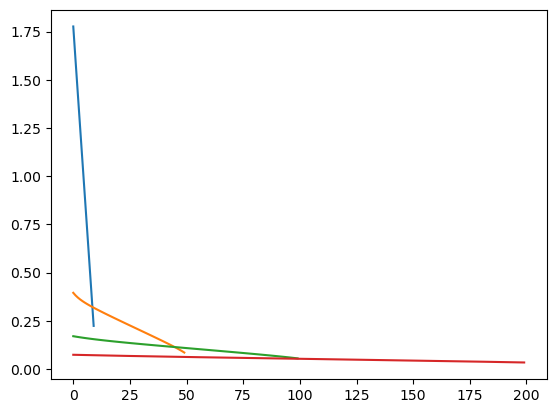

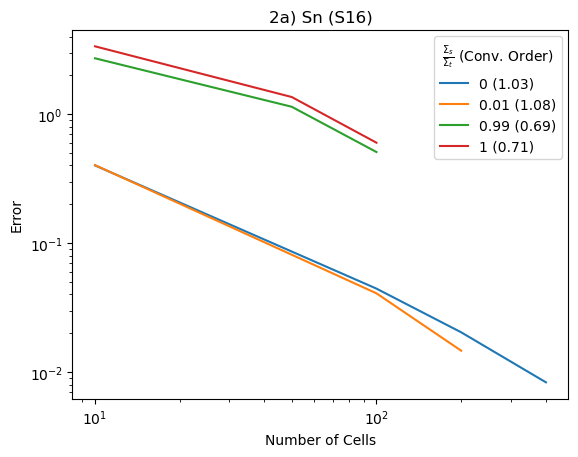

In [ ]:
number_of_angles = 16
angles, weights = np.polynomial.legendre.leggauss(number_of_angles)
length = 10

number_of_cells = {
    0 : [10, 100, 200, 400, 1600],
    0.01 : [10, 100, 200, 400],
    0.99 : [10, 50, 100, 200],
    1 : [10, 50, 100, 200],
}

def problem_a(n_cells, sigma_s, sigma_t):
    material = Material(sigma_t, sigma_s, 0)
    dx = length / n_cells
    mesh = Mesh([length], [material], dx)
    
    do = DiscreteOrdinates(
                        angles=angles,
                        weights=weights,
                        mesh=mesh,
                        left_boundary=1,
                        right_boundary=0,
                        )
        
    solution = do.angular_flux()
    
    return solution

test_convergence(problem_a, number_of_cells, name="a")

<>:24: SyntaxWarning: invalid escape sequence '\S'
<>:24: SyntaxWarning: invalid escape sequence '\S'
C:\Users\bpeco\AppData\Local\Temp\ipykernel_17524\2479553891.py:24: SyntaxWarning: invalid escape sequence '\S'
  title_start=f"b-N{n_cells}-$\Sigma_s${sigma_s}",


b-N100-$\Sigma_s$0: Converged after 1 iterations
b-N200-$\Sigma_s$0: Converged after 1 iterations
b-N400-$\Sigma_s$0: Converged after 1 iterations


C:\Users\bpeco\AppData\Local\Temp\ipykernel_17524\184657609.py:374: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_sol.show()


b-N100-$\Sigma_s$0.01: Converged after 3 iterations
b-N200-$\Sigma_s$0.01: Converged after 3 iterations
b-N400-$\Sigma_s$0.01: Converged after 3 iterations
b-N50-$\Sigma_s$0.99: Converged after 235 iterations
b-N100-$\Sigma_s$0.99: Converged after 236 iterations
b-N200-$\Sigma_s$0.99: Converged after 236 iterations
b-N50-$\Sigma_s$1: Converged after 316 iterations
b-N100-$\Sigma_s$1: Converged after 318 iterations
b-N200-$\Sigma_s$1: Converged after 319 iterations


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sn $\\Sigma_s/\\Sigma_t=1$'}>,
 <Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '2b) Sn (S16)'}, xlabel='Number of Cells', ylabel='Error'>)

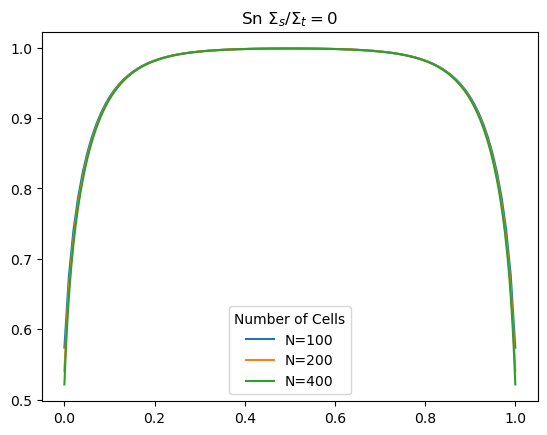

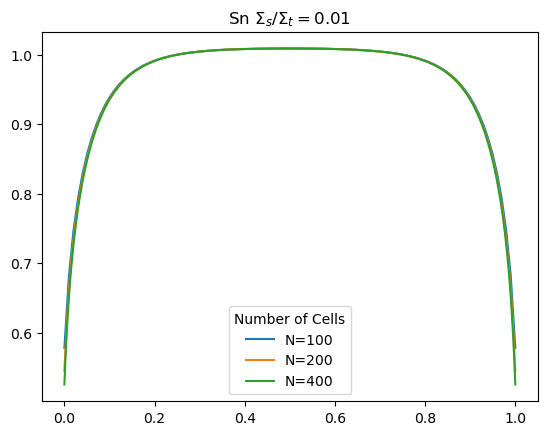

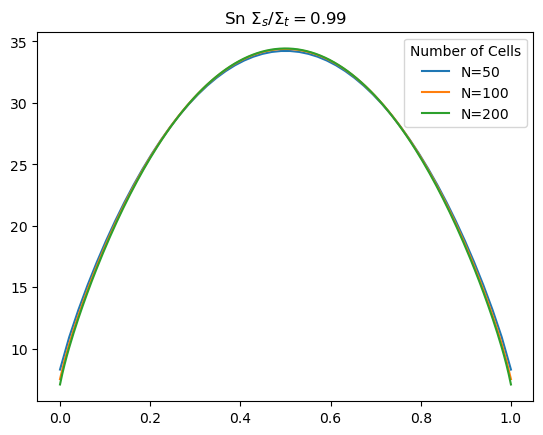

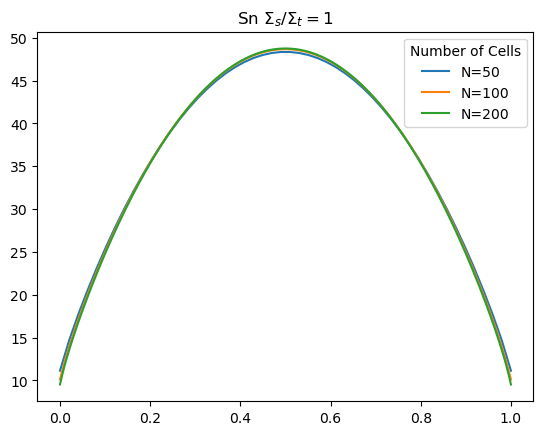

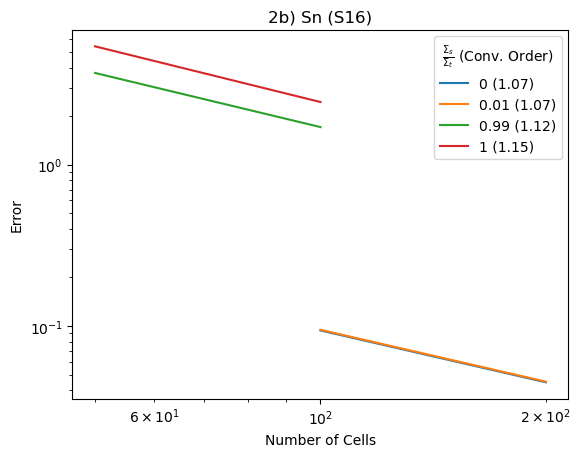

In [44]:
number_of_angles = 16
angles, weights = np.polynomial.legendre.leggauss(number_of_angles)
length = 10

number_of_cells = {
    0: [100, 200, 400],
    0.01: [100, 200, 400],
    0.99: [50, 100, 200],
    1: [50, 100, 200],
}


def problem_b(n_cells, sigma_s, sigma_t):
    material = Material(sigma_t, sigma_s, volumetric_source=1)
    dx = length / n_cells
    mesh = Mesh([length], [material], dx)

    do = DiscreteOrdinates(
        angles=angles,
        weights=weights,
        mesh=mesh,
        left_boundary=0,
        right_boundary=0,
        title_start=f"b-N{n_cells}-$\Sigma_s${sigma_s}",
    )

    solution = do.angular_flux()
    # do.plot()

    return solution


test_convergence(problem_b, number_of_cells, name="b", sigma_s_over_sigma_t_ratios=list(number_of_cells.keys()))

reflector-scatterer: Converged after 69 iterations
reflector-air: Converged after 32 iterations
reflector-source: Converged after 31 iterations
reflector-absorber: Converged after 32 iterations
absorber-source: Converged after 9 iterations
absorber-air: Converged after 10 iterations
source-air: Converged after 3 iterations


Text(0.5, 0, 'Position (cm)')

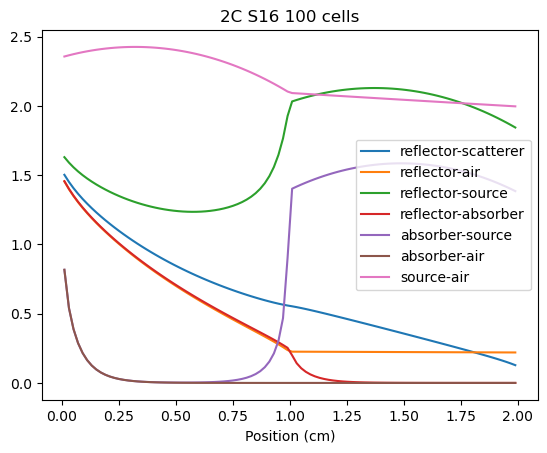

In [9]:
number_of_angles = 16
angles, weights = np.polynomial.legendre.leggauss(number_of_angles)

a_width = 1
b_width = 1
number_of_cells = 100

materials = {
    "reflector": {"sigma_t": 2, "sigma_s": 1.8, "volumetric_source" : 0},
    "scatterer": {"sigma_t": 2, "sigma_s": 1.99, "volumetric_source" : 0},
    "absorber": {"sigma_t": 10, "sigma_s": 2, "volumetric_source" : 0},
    "air": {"sigma_t": 0.01, "sigma_s": 0.006, "volumetric_source" : 0},
    "source": {"sigma_t": 0.1, "sigma_s": 0, "volumetric_source" : 1},
}

combos = [
    ["reflector", "scatterer"],
    ["reflector", "air"],
    ["reflector", "source"],
    ["reflector", "absorber"],
    ["absorber", "source"],
    ["absorber", "air"],
    ["source", "air"],
]

fig, ax = plt.subplots()
for combo in combos:
    material_a = Material(**materials[combo[0]])
    material_b = Material(**materials[combo[1]])
    mesh = Mesh([a_width, b_width], [material_a, material_b], (a_width + b_width) / number_of_cells)
    do = DiscreteOrdinates(
        angles=angles,
        weights=weights,
        mesh=mesh,
        left_boundary=1,
        right_boundary=0,
        title_start=f"{combo[0]}-{combo[1]}",
    )
    
    solution = do.angular_flux()
    x_pos = mesh.get_cell_x_positions()
    ax.plot(x_pos, solution, label=f"{combo[0]}-{combo[1]}",)


ax.legend()
ax.set_title(f"2C S16 {number_of_cells} cells")
ax.set_xlabel("Position (cm)")

reflector-scatterer: Converged after 65 iterations
reflector-air: Converged after 30 iterations
reflector-source: Converged after 31 iterations
reflector-absorber: Converged after 31 iterations
absorber-source: Converged after 8 iterations
absorber-air: Converged after 8 iterations
source-air: Converged after 3 iterations


Text(0.5, 0, 'Position (cm+0.5)')

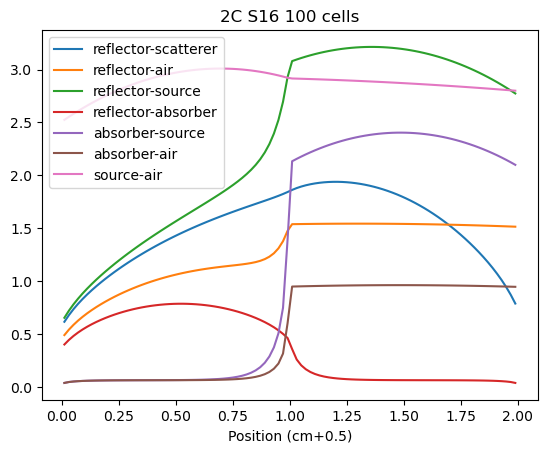

In [11]:
number_of_angles = 16
angles, weights = np.polynomial.legendre.leggauss(number_of_angles)

a_width = 1
b_width = 1
number_of_cells = 100

materials = {
    "reflector": {"sigma_t": 2, "sigma_s": 1.8, "volumetric_source": 0+0.5},
    "scatterer": {"sigma_t": 2, "sigma_s": 1.99, "volumetric_source": 0+0.5},
    "absorber": {"sigma_t": 10, "sigma_s": 2, "volumetric_source": 0+0.5},
    "air": {"sigma_t": 0.01, "sigma_s": 0.006, "volumetric_source": 0+0.5},
    "source": {"sigma_t": 0.1, "sigma_s": 0, "volumetric_source": 1+0.5},
}

combos = [
    ["reflector", "scatterer"],
    ["reflector", "air"],
    ["reflector", "source"],
    ["reflector", "absorber"],
    ["absorber", "source"],
    ["absorber", "air"],
    ["source", "air"],
]

fig, ax = plt.subplots()
for combo in combos:
    material_a = Material(**materials[combo[0]])
    material_b = Material(**materials[combo[1]])
    mesh = Mesh(
        [a_width, b_width],
        [material_a, material_b],
        (a_width + b_width) / number_of_cells,
    )
    do = DiscreteOrdinates(
        angles=angles,
        weights=weights,
        mesh=mesh,
        left_boundary=0,
        right_boundary=0,
        title_start=f"{combo[0]}-{combo[1]}",
    )

    solution = do.angular_flux()
    x_pos = mesh.get_cell_x_positions()
    ax.plot(
        x_pos,
        solution,
        label=f"{combo[0]}-{combo[1]}",
    )


ax.legend()
ax.set_title(f"2C S16 {number_of_cells} cells")
ax.set_xlabel("Position (cm+0.5)")

reflector-scatterer: Converged after 64 iterations
reflector-scatterer: Converged after 65 iterations
reflector-scatterer: Converged after 65 iterations
reflector-air: Converged after 30 iterations
reflector-air: Converged after 30 iterations
reflector-air: Converged after 30 iterations
reflector-source: Converged after 31 iterations
reflector-source: Converged after 31 iterations
reflector-source: Converged after 31 iterations
reflector-absorber: Converged after 31 iterations
reflector-absorber: Converged after 31 iterations
reflector-absorber: Converged after 31 iterations
absorber-source: Converged after 8 iterations
absorber-source: Converged after 8 iterations
absorber-source: Converged after 8 iterations
absorber-air: Converged after 8 iterations
absorber-air: Converged after 8 iterations
absorber-air: Converged after 8 iterations
source-air: Converged after 3 iterations
source-air: Converged after 3 iterations
source-air: Converged after 3 iterations


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '2c) Sn (S8)'}, xlabel='Number of Cells', ylabel='Error'>)

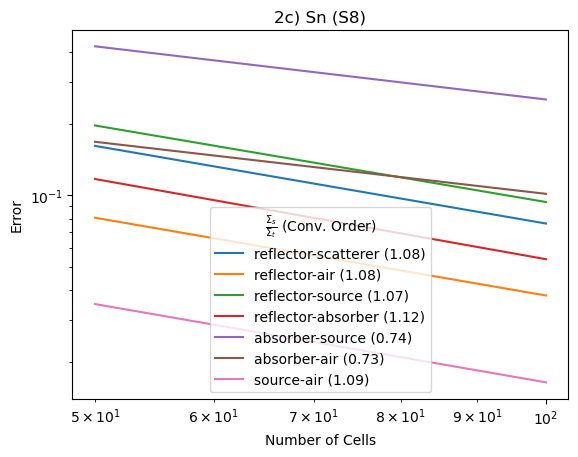

In [22]:
number_of_angles = 8
angles, weights = np.polynomial.legendre.leggauss(number_of_angles)

a_width = 1
b_width = 1

materials = {
    "reflector": {"sigma_t": 2, "sigma_s": 1.8, "volumetric_source": 0+0.5},
    "scatterer": {"sigma_t": 2, "sigma_s": 1.99, "volumetric_source": 0+0.5},
    "absorber": {"sigma_t": 10, "sigma_s": 2, "volumetric_source": 0+0.5},
    "air": {"sigma_t": 0.01, "sigma_s": 0.006, "volumetric_source": 0+0.5},
    "source": {"sigma_t": 0.1, "sigma_s": 0, "volumetric_source": 1+0.5},
}

combos = [
    ["reflector", "scatterer"],
    ["reflector", "air"],
    ["reflector", "source"],
    ["reflector", "absorber"],
    ["absorber", "source"],
    ["absorber", "air"],
    ["source", "air"],
]


def test_convergence2(
    number_of_cells,
    material_combos, name="a",
):
    orders_of_convergence = {}
    error_dict = {}

    for combo in material_combos:
        solutions = []
        for n_cells in number_of_cells:
            material_a = Material(**materials[combo[0]])
            material_b = Material(**materials[combo[1]])
            mesh = Mesh(
                [a_width, b_width],
                [material_a, material_b],
                (a_width + b_width) / n_cells,
            )
            do = DiscreteOrdinates(
                angles=angles,
                weights=weights,
                mesh=mesh,
                left_boundary=0,
                right_boundary=0,
                title_start=f"{combo[0]}-{combo[1]}",
            )

            solution = do.angular_flux()
            solutions.append(solution)
            x_pos = mesh.get_cell_x_positions()

        truth = solutions[-1]
        errors = []
        for solution in solutions[:-1]:
            step = int(len(truth) / len(solution))
            sliced_truth = truth[::step]
            error = np.linalg.norm(np.array(sliced_truth) - np.array(solution))
            errors.append(error)
        error_dict[f"{combo[0]}-{combo[1]}"] = errors
        orders_of_convergence[f"{combo[0]}-{combo[1]}"] = order_of_convergence(
            number_of_cells[:-1], errors
        )

    fig, ax = plt.subplots()

    for combo_string, errors in error_dict.items():
        ax.plot(
            number_of_cells[:-1],
            errors,
            label=f"{combo_string} ({orders_of_convergence[combo_string]:.2f})",
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(title=rf"$\frac{{\Sigma_s}}{{\Sigma_t}}$ (Conv. Order)")
    ax.set_xlabel("Number of Cells")
    ax.set_ylabel("Error")
    ax.set_title(f"2{name}) Sn (S{number_of_angles})")

    return fig, ax

number_of_cells = [50, 100, 200]
test_convergence2(number_of_cells, combos, name="c")